# VIT 

This notebook is for traning a Vision Transformer model for dog emotion detection

#### REF
[VIT TIMM](https://huggingface.co/timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)<br>
[Pytorch](https://pytorch.org/docs/stable/index.html)<br>
[Grad-CAM](https://github.com/jacobgil/pytorch-grad-cam/blob/master/usage_examples/vit_example.py#L55)


## Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import timm
import matplotlib.pyplot as plt
import sys
from pytorch_grad_cam import GradCAM
sys.path.insert(1, '/mnt/c/Eclipse/IU Spring 2025/is_the_dog_happy')

from get_data_loaders import *

/home/eclipse/anaconda3/envs/DOG_EMOTION/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/eclipse/anaconda3/envs/DOG_EMOTION/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/eclipse/anaconda3/envs/DOG_EMOTION/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data Processing

In [ ]:
train_loader, vali_loader, test_loader, num_classes = get_loaders("../data")

In [4]:
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

unnormalize = transforms.Normalize(
    mean=[-m/s for (m,s) in zip(MEAN, STD)],
    std =[1.0/s for s in STD]
)

In [5]:
def vis_samples(loader, rows=3, cols=3, show_mask=False, alpha=.35):
    fig = plt.figure(figsize=(cols*3, rows*3))

    for i in range(1, rows*cols+1):
        idx = torch.randint(len(loader.dataset), (1,)).item()
        img, label = loader.dataset[idx]

        # split channels
        if img.shape[0] == 4:
            rgb, mask = img[:3], img[3:]
        else:
            rgb, mask = img, None

        rgb = unnormalize(rgb.clone())
        rgb_np = rgb.permute(1,2,0).numpy().clip(0,1)

        ax = fig.add_subplot(rows, cols, i)
        ax.axis("off")
        ax.set_title(loader.dataset.classes[label])

        ax.imshow(rgb_np)

        if show_mask and mask is not None:
            m = mask.squeeze().numpy()
            ax.imshow(m, cmap="Reds", alpha=alpha)

    plt.tight_layout(); plt.show()


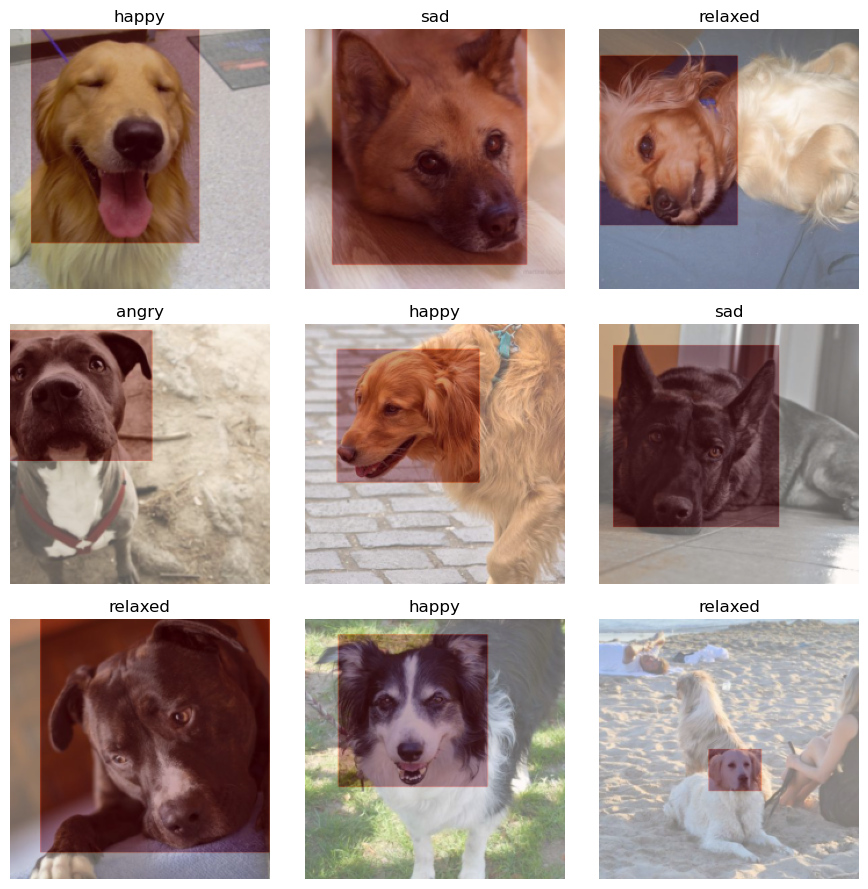

In [ ]:
vis_samples(train_loader, rows=3, cols=3)

## Model

In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
creterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = creterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch: {epoch}, Loss: {avg_loss}")

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in vali_loader:
            data, target = data.to(device), target.to(device)

            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        val_accuracy = 100 * correct / total
        print(f"Validation accuracy: {val_accuracy}")

torch.save(model.state_dict(), "vit_model.pth")

Epoch: 0, Loss: 1.3237504989058528
Validation accuracy: 37.09170854271357
Epoch: 1, Loss: 1.320124249262626
Validation accuracy: 38.47361809045226
Epoch: 2, Loss: 1.3148248752756933
Validation accuracy: 37.78266331658291


KeyboardInterrupt: 

## Grad-CAM

In [ ]:
def reshape_transformer_tensors(tensor):
    # remove CLS token
    activations = tensor[:, 1:, :]
    # reshape from [batch_size, num_tokens, features] to [batch_size, height, width, features]
    activations = activations.view(activations.shape[0], 14, 14, activations.shape[-1])
    # transpose to [batch_size, features, height, width]
    activations = activations.transpose(2, 3).transpose(1, 2)
    return activations

In [ ]:
target_layer = [model.blocks[-1].norm1]

In [ ]:
model = model.to(device).eval()
cam = GradCAM(model=model,
        target_layers=target_layer,
        reshape_transform=reshape_transformer_tensors)

In [ ]:
sample_idx = torch.randint(len(test_loader.dataset), size=(1,)).item()
rgb_img, _ = test_loader.dataset[sample_idx]
unnormalized_rgb_img = unnormalize(rgb_img.clone())
unnormalized_rgb_img = unnormalized_rgb_img.unsqueeze(0)
unnormalized_rgb_img = unnormalized_rgb_img.clip(0, 1)
unnormalized_rgb_img.shape

torch.Size([1, 3, 224, 224])

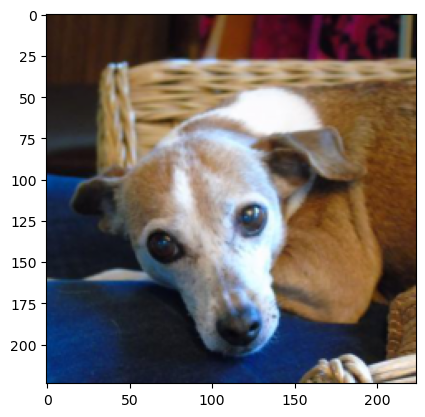

In [ ]:
plt.imshow(unnormalized_rgb_img.squeeze(0).permute(1, 2, 0))

In [ ]:
cam.batch_size = 16

grayscale_cam = cam(input_tensor=unnormalized_rgb_img.clone(),
                        targets=None,
                        eigen_smooth=True,
                        aug_smooth=True)

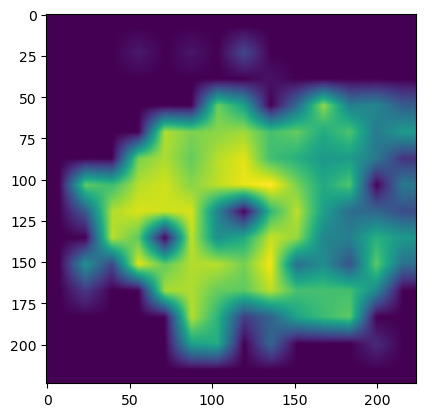

In [ ]:
grayscale_cam = grayscale_cam[0, :]
# cam_image = show_cam_on_image(rgb_img, grayscale_cam)
plt.imshow(grayscale_cam)